# AIRCRAFT FUEL CONSUMPTION MODELING
+ Author: Dinh Quang-Dung

+ Instructor: Jérôme Lacaille

In [1]:
'''
    Changelog 19/1:
        1. Normalize data, make a correlation matrix between the variables 
        2. Try out linear regression on the dataset generated by get_consumption(), identifying the important features.
        3. Validate if the model is suitable
        4. Make plots
    Changelog 02/02:
        1. Re-organize the linear regression code
        2. Try clusterings on the data without the 'Weight' columns, then use the try 10-fold CV
        3. Make some plots of the distribution of the clusters with respect to the 'Weight' variables
'''

'\n    Changelog 19/1:\n        1. Normalize data, make a correlation matrix between the variables \n        2. Try out linear regression on the dataset generated by get_consumption(), identifying the important features.\n        3. Validate if the model is suitable\n        4. Make plots\n'

## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import tabata as tbt
from tabata import Opset
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
from utils import get_consumption, detect_phase
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [3]:
datadir = os.getcwd()

In [4]:
# Reading the database by Opset() class
# Each .h5 files contains a number of flight info recordings of an aircraft
ac1 = Opset('Aircraft_01.h5')
ac2 = Opset('Aircraft_02.h5')
ac3 = Opset('Aircraft_03.h5')

In [5]:
#View a dataset 
ac1[2].head(5)

,ALT [ft],EGT_1 [deg C],EGT_2 [deg C],FMV_1 [mm],FMV_2 [mm],HPTACC_1 [%],HPTACC_2 [%],M [Mach],N1_1 [% rpm],N1_2 [% rpm],...,VIB_AN1_1 [mils],VIB_AN1_2 [mils],VIB_AN2_1 [ips],VIB_AN2_2 [ips],VIB_BN1_1 [mils],VIB_BN1_2 [mils],VIB_BN2_1 [ips],VIB_BN2_2 [ips],VSV_1 [mm],VSV_2 [mm]
record_02,,,,,,,,,,,,,,,,,,,,,
0,-32.456484,32.509804,35.465241,-0.645530,-0.64913,34.301983,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
1,-32.456484,32.509804,35.465241,-0.645530,-0.64913,34.301983,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
2,-32.456484,32.509804,34.480095,-0.726222,-0.64913,34.361312,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
3,-32.456484,32.509804,34.480095,-0.645530,-0.64913,34.301983,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
4,-32.456484,32.509804,34.480095,-0.645530,-0.64913,34.361312,3.955259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748


In [6]:
#Double plot to visualize the variables
from ipywidgets import interact, widgets

def mydoubleplot(varname, record):
    df = ac1[record]
    tbt.doubleplot(df[varname], df["ALT [ft]"], title="Vol {}".format(record))

interact(mydoubleplot, varname=ac1.df.columns, record=widgets.IntSlider(0,0,len(ac1)-1,1)) ; #range(len(ac1))) ;

interactive(children=(Dropdown(description='varname', options=('ALT [ft]', 'EGT_1 [deg C]', 'EGT_2 [deg C]', '…

# Preprocessing

In [7]:
all_phases = ['taxi','climb','cruise','descend', 'whole_flight']
def get_df(phase):
    dfc1 = get_consumption(ac1, phase)
    dfc2 = get_consumption(ac2, phase)
    dfc3 = get_consumption(ac3, phase)
    df = pd.concat([dfc1,dfc2,dfc3])
    return df

climb = get_df('climb')
cruise = get_df('cruise')
descend = get_df('descend')
whole_flight = get_df('whole_flight')

Record is incomplete
384
Record is incomplete
519
Record is incomplete
855
Record is incomplete
895
Record is incomplete
519
Record is incomplete
384
Record is incomplete
519
Record is incomplete
855
Record is incomplete
895
Record is incomplete
519
Record is incomplete
384
Record is incomplete
519
Record is incomplete
855
Record is incomplete
895
Record is incomplete
519
Record is incomplete
384
Record is incomplete
519
Record is incomplete
855
Record is incomplete
895
Record is incomplete
519


In [8]:
def extract(dataframe):
    df = dataframe[dataframe['ENG'] == 'Left'].drop(columns = ['Flight', 'AC', 'ENG', 'Volume'])
    df.index = np.arange(len(df))
    df.dropna(inplace = True) # drop na values
    df = df[df['Weight'] != 0] # drop weight = 0
    return df

df_climb = extract(climb)
df_cruise = extract(cruise)
df_descend = extract(descend)
df_whole_flight = extract(whole_flight)

**Comment** Think of a way to deal with nan or 0

In [9]:
def plot_distribution(df):
    plt.figure(figsize=(15,5))
    i = 0 
    for col in df.columns:
        i+=1
        plt.subplot(2,5,i)
        plt.hist(df[col],bins = 30)
        plt.title(col)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

Most of the features are skewed so we may only normalize the data to interval [0,1] by MinMaxScaler

In [10]:
from sklearn.preprocessing import MinMaxScaler
def preprocess(df):
    scaler = MinMaxScaler()
    scaler.fit(df.drop(columns = ['Weight']))
    df_transformed = scaler.transform(df.drop(columns = ['Weight']))
    df_transformed = np.concatenate([df_transformed, df[['Weight']].to_numpy()] ,axis=1) # Merge in numpy to ensure correct concatenation
    df_transformed = pd.DataFrame(df_transformed)
    df_transformed.columns = df.columns
    return df_transformed

df_climb_transformed = preprocess(df_climb)
df_cruise_transformed = preprocess(df_cruise)
df_descend_transformed = preprocess(df_descend)
df_whole_flight_transformed = preprocess(df_whole_flight)

In [11]:
indicators = list(df_climb_transformed.drop(columns=['Weight']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)
formula

'Weight ~ Duration + Alt_max + M_max + Alt_slope + Avg_egt + PS3 + TAT_max + TAT_min + T_oil_range'

In [ ]:
def linear_regression_result(df, drop_columns):
    indicators = list(df.drop(columns=drop_columns).columns)
    formula = 'Weight'+' ~ '+' + '.join(indicators)

    model = smf.ols(formula, data = df)
    res = model.fit()
    print(res.summary())
    return res

## 1. Climb

In [12]:
indicators = list(df_climb_transformed.drop(columns=['Weight', 'Duration']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)

model = smf.ols(formula, data = df_climb_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     1339.
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:00:55   Log-Likelihood:                -18621.
No. Observations:                2991   AIC:                         3.726e+04
Df Residuals:                    2982   BIC:                         3.731e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2151.6275     44.964     47.852      

In [13]:
indicators = list(df_climb_transformed.drop(columns=['Weight', 'Duration', 'M_max', 'TAT_max', 'PS3']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)

model = smf.ols(formula, data = df_climb_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     2142.
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:00:55   Log-Likelihood:                -18623.
No. Observations:                2991   AIC:                         3.726e+04
Df Residuals:                    2985   BIC:                         3.729e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2172.9634     38.107     57.023      

## 2. Cruise

In [14]:
indicators = list(df_cruise_transformed.drop(columns=['Weight', 'Duration']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)

model = smf.ols(formula, data = df_cruise_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     709.4
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:00:55   Log-Likelihood:                -23291.
No. Observations:                2992   AIC:                         4.660e+04
Df Residuals:                    2983   BIC:                         4.665e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1315.2632    197.648      6.655      

## 3. Descend

In [15]:
indicators = list(df_descend_transformed.drop(columns=['Weight', 'Duration']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)

model = smf.ols(formula, data = df_descend_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1442.
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:00:55   Log-Likelihood:                -18771.
No. Observations:                2991   AIC:                         3.756e+04
Df Residuals:                    2982   BIC:                         3.761e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     972.3829     32.052     30.338      

In [16]:
indicators = list(df_descend_transformed.drop(columns=['Weight', 'Duration', 'PS3']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)

model = smf.ols(formula, data = df_descend_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1647.
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:00:55   Log-Likelihood:                -18772.
No. Observations:                2991   AIC:                         3.756e+04
Df Residuals:                    2983   BIC:                         3.761e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     997.4031     28.259     35.295      

## 4. Whole flight

In [17]:
indicators = list(df_whole_flight_transformed.drop(columns=['Weight', 'Duration']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)

model = smf.ols(formula, data = df_whole_flight_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     4331.
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:00:55   Log-Likelihood:                -21461.
No. Observations:                2992   AIC:                         4.294e+04
Df Residuals:                    2983   BIC:                         4.299e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2970.7414     82.552     35.986      

In [18]:
indicators = list(df_whole_flight_transformed.drop(columns=['Weight', 'Duration', 'M_max', 'TAT_max']).columns)
formula = 'Weight'+' ~ '+' + '.join(indicators)

model = smf.ols(formula, data = df_whole_flight_transformed)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     5771.
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:00:56   Log-Likelihood:                -21463.
No. Observations:                2992   AIC:                         4.294e+04
Df Residuals:                    2985   BIC:                         4.298e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2947.5960     80.790     36.485      

# Clustering

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

In [159]:
np.random.seed(10)
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters,n_init = 'auto')
clusters = kmeans.fit_predict(df_whole_flight_transformed.drop(columns = ['Weight']))
color = []
for n in range(n_clusters):
    color += [np.random.rand(3)]
color_list = [color[clusters[j]] for j in range(len(clusters))]

In [160]:
_, counts = np.unique(clusters, return_counts= True)
counts

array([ 847, 1115, 1030], dtype=int64)

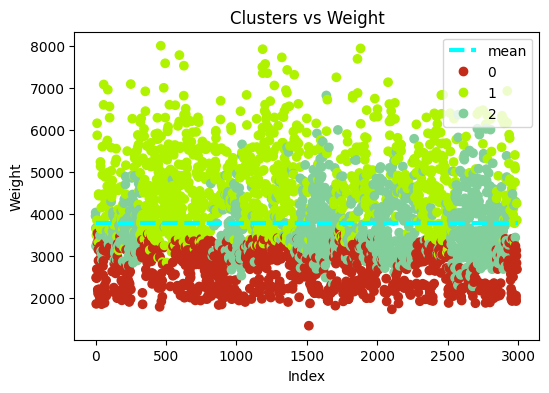

In [161]:
# Visualization with respect to the weight
n = np.arange(len(df_whole_flight_transformed))
weight = df_whole_flight_transformed.iloc[:,-1]
mean_weight = np.mean(weight)
plt.figure(figsize=(6,4))
plt.plot([0,3000],[mean_weight]*2, c = 'cyan', linestyle = '--',linewidth = 3.0, label = 'mean')
plt.scatter(n, weight, c = color_list)
plt.xlabel('Index')
plt.ylabel('Weight')
handles, labels = plt.gca().get_legend_handles_labels()
custom_legends = [Line2D([0],[0], color = color[0], marker = 'o', linestyle= '', label = '0'),
                  Line2D([0],[0], color = color[1], marker = 'o', linestyle= '', label = '1'),
                  Line2D([0],[0], color = color[2], marker = 'o', linestyle= '', label = '2')]
handles.extend(custom_legends)
plt.legend(handles = handles)
plt.title('Clusters vs Weight')
plt.show()

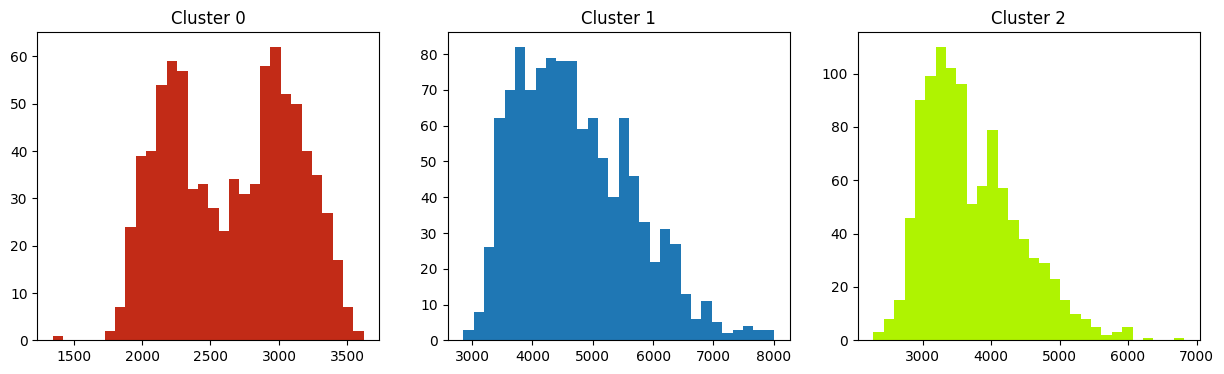

In [162]:
plt.figure(figsize= (15,4))
plt.subplot(1,3,1)
plt.hist(df_whole_flight_transformed['Weight'][clusters == 0], bins = 30, color = color[0])
plt.title('Cluster 0')
plt.subplot(1,3,2)
plt.hist(df_whole_flight_transformed['Weight'][clusters == 1], bins = 30)
plt.title('Cluster 1')
plt.subplot(1,3,3)
plt.hist(df_whole_flight_transformed['Weight'][clusters == 2], bins = 30, color = color[1])
plt.title('Cluster 2')
plt.show()

In [163]:
tsne = TSNE(n_components=2, perplexity= 5)
df_whole_flight_tsne = tsne.fit_transform(df_whole_flight_transformed.drop(columns = ['Weight']))

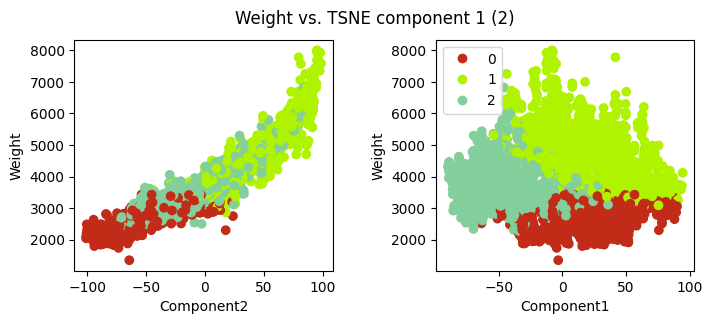

In [164]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(df_whole_flight_tsne[:,0], df_whole_flight['Weight'], c = color_list)
plt.xlabel('Component2')
plt.ylabel('Weight')
plt.subplot(1,2,2)
plt.scatter(df_whole_flight_tsne[:,1], df_whole_flight['Weight'], c = color_list)
plt.xlabel('Component1')
plt.ylabel('Weight')
plt.subplots_adjust(wspace = 0.4)
handles, labels = plt.gca().get_legend_handles_labels()
custom_legends = [Line2D([0],[0], color = color[0], marker = 'o', linestyle= '', label = '0'),
                  Line2D([0],[0], color = color[1], marker = 'o', linestyle= '', label = '1'),
                  Line2D([0],[0], color = color[2], marker = 'o', linestyle= '', label = '2')]
handles.extend(custom_legends)
plt.legend(handles = handles)
plt.suptitle('Weight vs. TSNE component 1 (2)')
plt.show()

# Trees

In [77]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [302]:
#RandomForestRegressor
reg1 = RandomForestRegressor(n_estimators = 100, random_state=10)
reg2 = RandomForestRegressor(n_estimators = 100, random_state=10, ccp_alpha= 1)
reg3 = RandomForestRegressor(n_estimators = 100, random_state=10, ccp_alpha=10,max_depth=9)
models = [reg1, reg2, reg3]

df_input = df_whole_flight_transformed.drop(columns = ['Duration','Weight'])
target = df_whole_flight_transformed['Weight']

def kCV(models: list, df_input, target):
    i=0
    for reg in models:
        i+=1
        print(f'Params set{i}')
        n_splits = 10
        fold = KFold(n_splits=n_splits)
        splits = fold.split(df_input,target)
        kfold_r2 = []
        kfold_mse = []
        for train_idx, test_idx in splits:
            X_train, X_test, y_train, y_test = df_input.iloc[train_idx,:], df_input.iloc[test_idx,:], target.iloc[train_idx], target.iloc[test_idx]
            reg.fit(X_train,y_train)
            r2 = r2_score(y_test,reg.predict(X_test))
            mse = mean_squared_error(y_test,reg.predict(X_test))
            kfold_r2.append(r2)
            kfold_mse.append(mse)
        mean_r2 = np.round(np.mean(kfold_r2),3)
        mean_mse = np.round(np.mean(kfold_mse),3)
        std_r2 = np.round(np.std(kfold_r2),3)
        std_mse = np.round(np.std(kfold_mse),3)
        print(f'{n_splits} - fold R2: {mean_r2} +- {std_r2}, Residual: {mean_mse} +- {std_mse}' )
        print(f'kfold r2: {np.round(kfold_r2,3)}')
        print(f'kfold mse: {np.round(kfold_mse,3)}')

kCV(models,df_input,target)

Params set1
10 - fold R2: 0.986 +- 0.013, Residual: 16469.081 +- 13708.46
kfold r2: [0.949 0.979 0.991 0.992 0.991 0.987 0.993 0.992 0.993 0.994]
kfold mse: [54405.287 26041.613 13741.579  9632.541 13769.671 14639.429  8474.347
  9497.052  7920.04   6569.254]
Params set2
10 - fold R2: 0.986 +- 0.013, Residual: 16491.289 +- 13719.443
kfold r2: [0.949 0.979 0.991 0.992 0.991 0.987 0.993 0.992 0.993 0.994]
kfold mse: [54468.712 26051.629 13743.283  9672.868 13774.274 14664.028  8481.206
  9519.681  7940.359  6596.851]
Params set3
10 - fold R2: 0.984 +- 0.013, Residual: 18498.145 +- 13258.216
kfold r2: [0.948 0.978 0.989 0.99  0.989 0.984 0.991 0.99  0.992 0.993]
kfold mse: [55161.836 27076.503 16232.73  11815.243 16829.045 17320.075 10860.122
 11661.748  9710.081  8314.065]


In [166]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [170]:
#RandomForestRegressor
clf1 = DecisionTreeClassifier(random_state=10)
clf2 = DecisionTreeClassifier(random_state=10, ccp_alpha= 1)
clf3 = DecisionTreeClassifier(random_state=10, ccp_alpha=10,max_depth=5)

models = [clf1, clf2, clf3]

df_input = df_whole_flight_transformed.drop(columns = ['Duration','Weight'])
target = pd.Series(clusters)

def kCV_clf(models: list, df_input, target):
    i=0
    for clf in models:
        i+=1
        print(f'Params set{i}')
        n_splits = 10
        fold = StratifiedKFold(n_splits=n_splits)
        splits = fold.split(df_input,target)
        kfold_acc = []
        kfold_b_acc = []
        kfold_f1 = []
        for train_idx, test_idx in splits:
            X_train, X_test, y_train, y_test = df_input.iloc[train_idx,:], df_input.iloc[test_idx,:], target.iloc[train_idx], target.iloc[test_idx]
            clf.fit(X_train,y_train)
            pred = clf.predict(X_test)
            acc = accuracy_score(y_test,pred)
            b_acc = balanced_accuracy_score(y_test,pred)
            f1 = f1_score(y_test,pred,average='weighted')
            kfold_acc.append(acc)
            kfold_b_acc.append(b_acc)
            kfold_f1.append(f1)

        mean_acc = np.round(np.mean(kfold_acc),3)
        mean_b_acc = np.round(np.mean(kfold_b_acc),3)
        mean_f1 = np.round(np.mean(kfold_f1),3)

        std_acc = np.round(np.std(kfold_acc),3)
        std_b_acc = np.round(np.std(kfold_b_acc),3)
        std_f1 = np.round(np.std(kfold_f1),3)

        print(f'{n_splits} - fold Accuracy: {mean_acc} +- {std_acc}, Balanced accuracy: {mean_b_acc} +- {std_b_acc}, f1: {mean_f1} +- {std_f1}' )

kCV_clf(models,df_input,target)

Params set1
10 - fold Accuracy: 0.918 +- 0.019, Balanced accuracy: 0.918 +- 0.019, f1: 0.918 +- 0.019
Params set2
10 - fold Accuracy: 0.373 +- 0.001, Balanced accuracy: 0.333 +- 0.0, f1: 0.202 +- 0.001
Params set3
10 - fold Accuracy: 0.373 +- 0.001, Balanced accuracy: 0.333 +- 0.0, f1: 0.202 +- 0.001


In [173]:
from sklearn.model_selection import GridSearchCV
params_grid = {'ccp_alpha': [5**i for i in range(-5,5)],
               'max_depth': [3,5,7,9],
               'max_features': [3,5,7,9]}
gs = GridSearchCV(DecisionTreeClassifier(), params_grid, scoring = 'balanced_accuracy',n_jobs = -1,verbose=True)
gs.fit(df_input,target)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.00032, 0.0016, 0.008, 0.04, 0.2, 1, 5,
                                       25, 125, 625],
                         'max_depth': [3, 5, 7, 9],
                         'max_features': [3, 5, 7, 9]},
             scoring='balanced_accuracy', verbose=True)

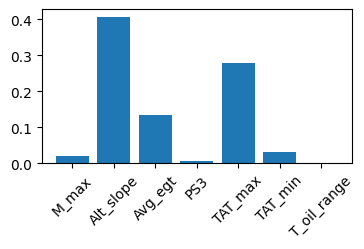

In [174]:
features_importance = gs.best_estimator_.feature_importances_[1:] #Without duration variable
features = gs.best_estimator_.feature_names_in_[1:] #Without duration variable
n_features = len(features)
plt.figure(figsize=(4,2))
plt.bar(np.arange(n_features), features_importance)
plt.xticks(np.arange(n_features), features,rotation =45)
plt.show()

In [175]:
print(gs.best_params_)
print(gs.best_score_)

{'ccp_alpha': 0.00032, 'max_depth': 9, 'max_features': 9}
0.9166445526383817


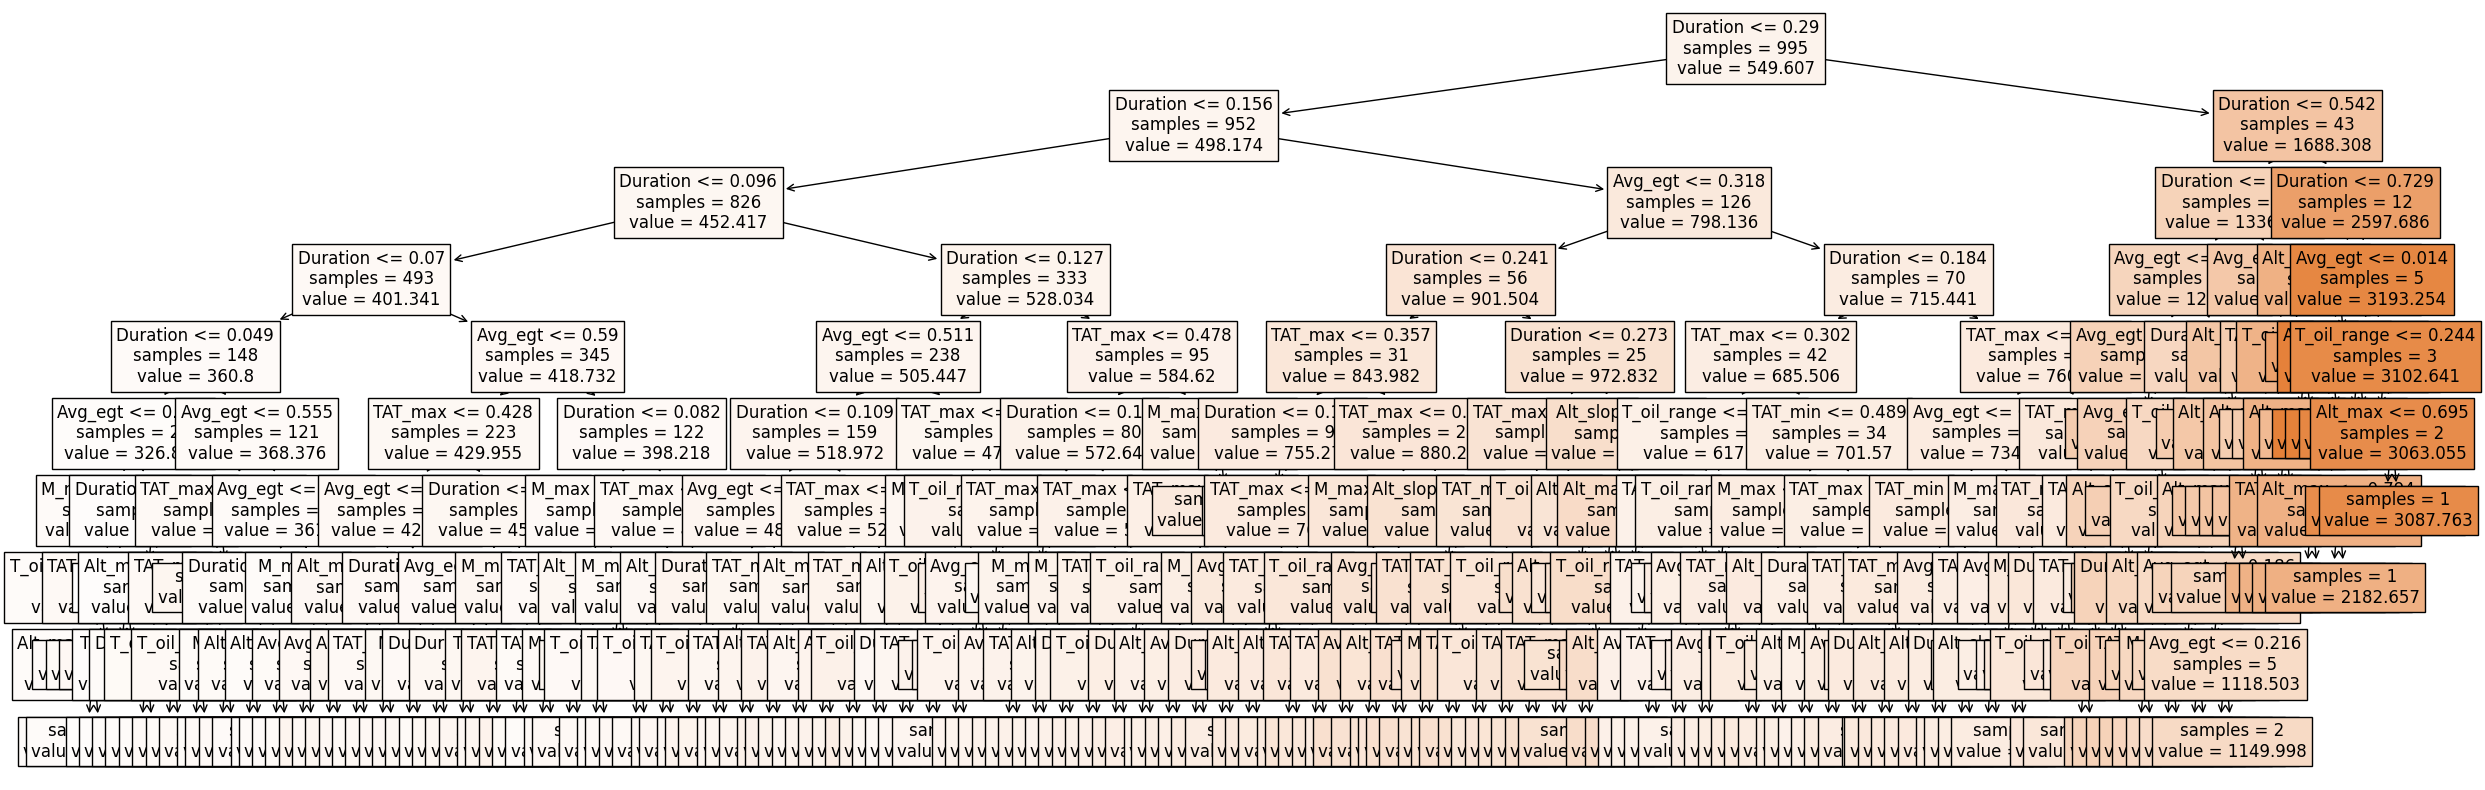

In [162]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(gs.best_estimator_, 
                   feature_names=df_input.columns,
                   filled=True,fontsize=12,impurity=False)

In [166]:
svr1 = SVR(kernel = 'linear', C = 20)
svr2 = SVR(kernel = 'poly', degree = 4)
svr3 = SVR(kernel = 'linear',tol = 0.01)

kCV([svr1,svr2,svr3], df_input, target)

Params set1
10 - fold R2: 0.64 +- 0.142, Residual: 43018.165 +- 37512.368
kfold r2: [0.68  0.832 0.809 0.461 0.483 0.479 0.677 0.648 0.512 0.823]
kfold mse: [21934.883  4474.375  7200.612 99997.854 79022.437 96906.074 20087.92
 21837.505 74077.939  4642.049]
Params set2
10 - fold R2: 0.84 +- 0.066, Residual: 15386.044 +- 11622.809
kfold r2: [0.898 0.902 0.815 0.92  0.81  0.779 0.811 0.698 0.874 0.897]
kfold mse: [ 7018.429  2616.585  6980.711 14860.88  29071.341 41090.576 11712.427
 18717.096 19080.819  2711.573]
Params set3
10 - fold R2: 0.016 +- 0.045, Residual: 96242.067 +- 64497.439
kfold r2: [ 0.069  0.094  0.079 -0.004 -0.035 -0.035 -0.017  0.016 -0.003 -0.002]
kfold mse: [ 63881.996  24135.974  34797.148 186325.639 158118.658 192473.871
  63158.916  61003.951 152267.331  26257.186]


In [167]:
params_grid = [{'kernel': ['poly'], 'degree': [2,3,4], 'C': [10,20,30,40], 'gamma': ['scale','auto']},
               {'kernel': ['linear'], 'C': [10,20,30,40]},
               {'kernel': ['rbf'],  'C': [10,20,30,40], 'gamma': ['scale','auto']}]
gs = GridSearchCV(SVR(),params_grid, scoring = 'neg_mean_squared_error',n_jobs = -1,verbose=True)
gs.fit(df_input,target)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [10, 20, 30, 40], 'degree': [2, 3, 4],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']},
                         {'C': [10, 20, 30, 40], 'kernel': ['linear']},
                         {'C': [10, 20, 30, 40], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=True)

In [168]:
print(gs.best_params_)
print(gs.best_score_)

{'C': 40, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
-11211.21901749048


In [172]:
len(sv_ind)

988

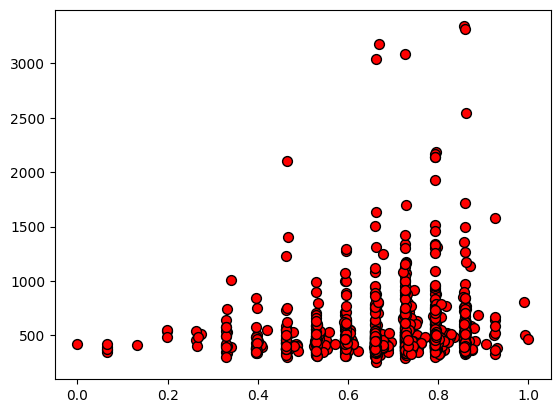

In [171]:
sv_ind = gs.best_estimator_.support_
plt.scatter(
    df_input.iloc[sv_ind,0],
    target[sv_ind],
    c="r",
    s=50,
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0),
)

In [126]:
# plot the learning curve 
from sklearn.model_selection import learning_curve
curve_svr = learning_curve(gs.best_estimator_, df_input, target, cv = 10,n_jobs=-1, verbose = 1)

[learning_curve] Training set sizes: [ 89 290 492 693 895]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


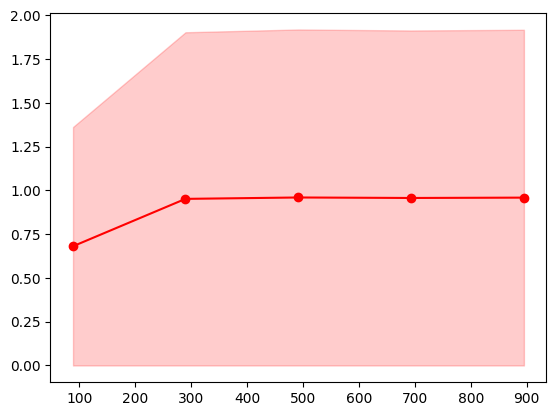

In [133]:
mean_test_score = curve_svr[2].mean(axis = 1)
sd_test_score = curve_svr[2].mean(axis = 1)
plt.fill_between(curve_svr[0], mean_test_score - sd_test_score, mean_test_score + sd_test_score,alpha = 0.2, color = color[0])
plt.plot(curve_svr[0], mean_test_score, 'o-r')